# **Modelo de regresión AdaBoost**
## Desarrollado por Jesus David Gomez Osorno
## Universidad de Antioquia

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
RUTA_DATA = '/content/drive/MyDrive/Monografía/data'
RUTA_DATA_MEDIANOS = RUTA_DATA + '/medianos'
RUTA_DATA_GRANDES = RUTA_DATA + '/grandes'
RUTA_RESULTADOS_MEDIANOS = RUTA_DATA + '/resultados/medianos'
RUTA_RESULTADOS_GRANDES = RUTA_DATA + '/resultados/grandes'

## 1. Caracteristicas

In [3]:
DEPARTAMENTO = 'DEPARTAMENTO'
MUNICIPIO = 'MUNICIPIO'
GRUPO_CULTIVO = 'GRUPO_CULTIVO'
CULTIVO = 'CULTIVO'
AREA_SEMBRADA = 'AREA_SEMBRADA'
AREA_COSECHADA = 'AREA_COSECHADA'
PRODUCCION = 'PRODUCCION'
ESTADO_FISICO_PRODUCCION = 'ESTADO_FISICO_PRODUCCION'
CICLO_CULTIVO = 'CICLO_CULTIVO'

In [4]:
columns = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_SEMBRADA,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

columns_feature = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

##Función de metricas

In [6]:
from sklearn.model_selection import cross_val_score # Método de validación cruzada para evaluar el desempeño un modelo
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score # Se llama a una clase llamada explained_variance_score, el cual es
                                                     # una métrica de varianza explicada
from sklearn.metrics import mean_absolute_error # Se llama a una clase llamada mean_absolute_error, el cual es
                                                # una métrica de error promedio absoluto
from sklearn.metrics import mean_gamma_deviance # 0.001 (Sensibilidad del modelo regresión)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_poisson_deviance                                            

def puntaje(X_Prueba_local, Y_Prueba_local, y_pred_local, estimador, name):
  Puntaje_1_R2 = estimador.score(X_Prueba_local, Y_Prueba_local) 

  # Error cuadrático medio
  Validacion_ECM = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 5, scoring = 'neg_mean_squared_error')
  Puntaje_2_ECM = np.array([Validacion_ECM.mean(), Validacion_ECM.std()]) 

  ## R Cuadrado
  Validacion_R2 = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 10, scoring = 'r2')
  Puntaje_3_R2 = np.array([Validacion_R2.mean(), Validacion_R2.std()]) 

  ## Varianza Explicada
  Puntaje_4 = explained_variance_score(Y_Prueba_local, y_pred_local) 
  ## ECM
  Puntaje_5 = mean_absolute_error(Y_Prueba_local, y_pred_local) 

  ## Pérdida media de regresión de la desviación de Poisson
  MN = MinMaxScaler(feature_range=(0, 1))

  Y_Prueba_R = Y_Prueba_local.values
  Y_Prueba_R = np.asarray(Y_Prueba_R)
  Y_merge = np.vstack([Y_Prueba_R, y_pred_local]).T
  Y_merge = MN.fit_transform(Y_merge)

  for _,n in enumerate(np.arange(0, Y_merge.shape[0])):
    if Y_merge[n,0] == 0:
      Y_merge[n,0] = 0.0001
    if Y_merge[n,1] == 0:
      Y_merge[n,1] = 0.0001

  Puntaje_6 = mean_poisson_deviance(Y_merge[:,0], Y_merge[:,1]) 
  Puntaje_7 = mean_gamma_deviance(Y_merge[:,0], Y_merge[:,1])

  return {'NOMBRE': name, 
          'R2_MODEL': Puntaje_1_R2, 
          'CROSS_ECM': Puntaje_2_ECM[0], 
          'CROSS_ECM_DE': Puntaje_2_ECM[1], 
          'CROSS_R2': Puntaje_3_R2[0], 
          'CROSS_R2_DE': Puntaje_3_R2[1],
          'VARIANZA_EXPL': Puntaje_4,
          'MAE': Puntaje_5,
          'MAE_POISSON': Puntaje_6,
          'MAE_GAMMA': Puntaje_7}


## Función grafica mejor

In [7]:
from sklearn.linear_model import HuberRegressor

def grafica_mejor(url, opc):
  data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
  data_after_features = data_after[columns_feature]
  data_after_estimados = data_after[AREA_SEMBRADA]

  X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)

  HUBER = HuberRegressor()
  HUBER.fit(X_Entrenamiento, Y_Entrenamiento)
  
  Y_pred = HUBER.predict(X_Prueba)

  fig = plt.figure(figsize=(12,8))
  line_1 = plt.plot(np.arange(len(Y_Prueba)), Y_Prueba, color = 'g', label='Y original') 
  line_2 = plt.plot(np.arange(len(Y_Prueba)), Y_pred, color = 'r', label='Y estimada por el modelo con regresión Huber') 
  plt.axhline(0, color="black") # Elegir color de la linea horizontal de referencia
  plt.legend()
  plt.title('Comparación entre Y salida original vs Y salida del modelo con regresión Huber') # Titulo de la gráfica
  plt.xlabel('muestras') # Etiqueta del eje x
  plt.ylabel('y') # Etiqueta del eje y

  plt.show() # Mostrar gráfica

## Función guardar resultados

In [8]:
from os.path import exists

def guardaResultados(url, filename, data):
  if not exists(url):
    np.savetxt(url, data, delimiter=',')

  data_after = pd.read_csv(url, header = None, index_col= False, names = columns_resultados)
  data_after = data_after[data_after['NOMBRE'] == filename ]

  if not len(data_after) > 0:
    print('dentro')
    np.savetxt(url, data, delimiter=',', fmt="%s")
  
  return len(data_after) > 0, pd.concat([data, data_after]);

##Medianos

In [9]:
import os
from sklearn.model_selection import train_test_split # Esta clase realiza la partición de datos en entrenamiento y prueba

columns_resultados = ['NOMBRE', 'CONFIG', 'R2_MODEL', 'CROSS_ECM', 'CROSS_ECM_DE', 'CROSS_R2', 'CROSS_R2_DE', 'VARIANZA_EXPL', 'MAE', 'MAE_POISSON', 'MAE_GAMMA']

In [10]:
df_resultados_medianos = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_MEDIANOS):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_MEDIANOS + '/huber_regressor.csv', filename, df_resultados_medianos )
      df_resultados_medianos = new_data
      if not is_save:
        url = RUTA_DATA_MEDIANOS + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]
        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)

        epsilon = [1.05, 1.25, 1.45]
        for opc in epsilon:
          HUBER = HuberRegressor(max_iter=1000, epsilon=opc)
          HUBER.fit(X_Entrenamiento, Y_Entrenamiento)
          
          Y_pred = HUBER.predict(X_Prueba)

          result = puntaje(X_Prueba, Y_Prueba, Y_pred, HUBER, filename)
          result['CONFIG'] = opc
          df_resultados_medianos = df_resultados_medianos.append(result, ignore_index=True)

robusto_original.csv
estandar_original.csv
min_max_original.csv
max_normalizacion_original.csv
robusto_lof_euclidean_5.csv
robusto_lof_minkowski_5.csv
robusto_lof_manhattan_5.csv
robusto_lof_euclidean_7.csv
robusto_lof_minkowski_7.csv
robusto_lof_manhattan_7.csv
robusto_lof_euclidean_9.csv
robusto_lof_minkowski_9.csv
robusto_lof_manhattan_9.csv
robusto_lof_euclidean_11.csv
robusto_lof_minkowski_11.csv
robusto_lof_manhattan_11.csv
estandar_lof_euclidean_5.csv
estandar_lof_minkowski_5.csv
estandar_lof_manhattan_5.csv
estandar_lof_euclidean_7.csv
estandar_lof_minkowski_7.csv
estandar_lof_manhattan_7.csv
estandar_lof_euclidean_9.csv
estandar_lof_minkowski_9.csv
estandar_lof_manhattan_9.csv
estandar_lof_euclidean_11.csv
estandar_lof_minkowski_11.csv
estandar_lof_manhattan_11.csv
min_max_lof_euclidean_5.csv
min_max_lof_minkowski_5.csv
min_max_lof_manhattan_5.csv
min_max_lof_euclidean_7.csv
min_max_lof_minkowski_7.csv
min_max_lof_manhattan_7.csv
min_max_lof_euclidean_9.csv
min_max_lof_minkows

In [11]:
pd.set_option("min_rows", 20)
df_resultados_medianos_sort = df_resultados_medianos.sort_values('MAE', False)
df_resultados_medianos_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
333,min_max_isf_400_0_2.csv,1.05,0.801617,-0.000012,1.732563e-06,0.799464,0.040152,0.829517,0.001292,0.088298,4.336807e+02
335,min_max_isf_400_0_2.csv,1.45,0.801697,-0.000012,1.715777e-06,0.799874,0.040091,0.829536,0.001293,0.141100,5.350367e+05
334,min_max_isf_400_0_2.csv,1.25,0.801431,-0.000012,1.716401e-06,0.799508,0.039912,0.829440,0.001295,0.066582,2.563104e+01
278,min_max_isf_100_auto.csv,1.45,0.825290,-0.000013,1.213365e-06,0.825338,0.033429,0.850171,0.001335,0.111238,1.051941e+05
277,min_max_isf_100_auto.csv,1.25,0.825316,-0.000013,1.215953e-06,0.825175,0.033566,0.850179,0.001336,0.142188,9.365399e+06
276,min_max_isf_100_auto.csv,1.05,0.825333,-0.000013,1.216771e-06,0.825275,0.033428,0.850184,0.001336,0.129226,1.148778e+06
289,min_max_isf_100_0_2.csv,1.25,0.803483,-0.000012,8.048686e-07,0.803162,0.017851,0.831937,0.001344,0.144001,6.227423e+05
288,min_max_isf_100_0_2.csv,1.05,0.803558,-0.000012,8.109204e-07,0.803240,0.017948,0.831936,0.001345,0.169198,1.146747e+07
290,min_max_isf_100_0_2.csv,1.45,0.803310,-0.000012,7.974071e-07,0.803502,0.017901,0.831875,0.001346,0.151806,1.627087e+06
305,min_max_isf_200_0_2.csv,1.45,0.791481,-0.000013,1.786320e-06,0.791405,0.039774,0.821609,0.001358,0.076653,8.368319e+01


### Mejor resultado

In [12]:
df_resultados_medianos_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
333,min_max_isf_400_0_2.csv,1.05,0.801617,-0.000012,0.000002,0.799464,0.040152,0.829517,0.001292,0.088298,433.68065


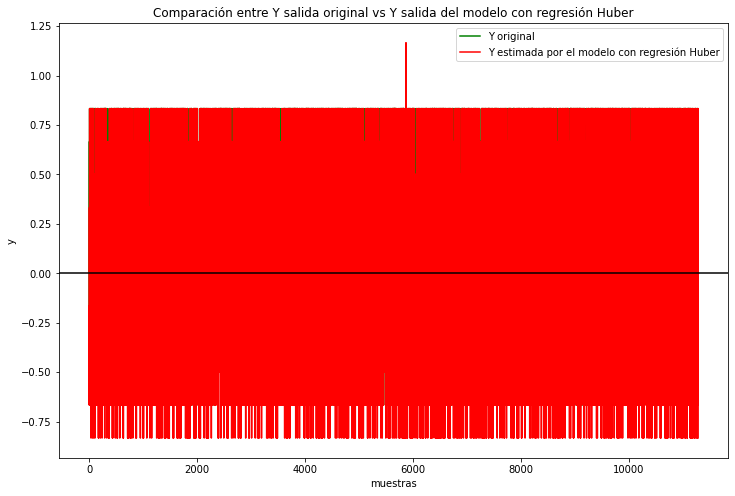

In [13]:
url = RUTA_DATA_MEDIANOS + '/' + df_resultados_medianos_sort.at[0,'NOMBRE']
opc = df_resultados_medianos_sort.at[0,'CONFIG']
grafica_mejor(url, opc)

## Grandes

In [14]:
df_resultados_grandes = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_GRANDES):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_GRANDES + '/huber_regressor.csv', filename, df_resultados_grandes )
      df_resultados_grandes = new_data
      if not is_save:
        url = RUTA_DATA_GRANDES + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]
        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)

        epsilon = [1.05, 1.25, 1.45]
        for opc in epsilon:
          HUBER = HuberRegressor(max_iter=1000, epsilon=opc)
          HUBER.fit(X_Entrenamiento, Y_Entrenamiento)
          
          Y_pred = HUBER.predict(X_Prueba)

          result = puntaje(X_Prueba, Y_Prueba, Y_pred, HUBER, filename)
          result['CONFIG'] = opc
          df_resultados_grandes = df_resultados_grandes.append(result, ignore_index=True)

robusto_original.csv
estandar_original.csv
min_max_original.csv
max_normalizacion_original.csv
robusto_lof_euclidean_5.csv
robusto_lof_minkowski_5.csv
robusto_lof_manhattan_5.csv
robusto_lof_euclidean_7.csv
robusto_lof_minkowski_7.csv
robusto_lof_manhattan_7.csv
robusto_lof_euclidean_9.csv
robusto_lof_minkowski_9.csv
robusto_lof_manhattan_9.csv
robusto_lof_euclidean_11.csv
robusto_lof_minkowski_11.csv
robusto_lof_manhattan_11.csv
estandar_lof_euclidean_5.csv
estandar_lof_minkowski_5.csv
estandar_lof_manhattan_5.csv
estandar_lof_euclidean_7.csv
estandar_lof_minkowski_7.csv
estandar_lof_manhattan_7.csv
estandar_lof_euclidean_9.csv
estandar_lof_minkowski_9.csv
estandar_lof_manhattan_9.csv
estandar_lof_euclidean_11.csv
estandar_lof_minkowski_11.csv
estandar_lof_manhattan_11.csv
min_max_lof_euclidean_5.csv
min_max_lof_minkowski_5.csv
min_max_lof_manhattan_5.csv
min_max_lof_euclidean_7.csv
min_max_lof_minkowski_7.csv
min_max_lof_manhattan_7.csv
min_max_lof_euclidean_9.csv
min_max_lof_minkows

In [15]:
pd.set_option("min_rows", 20)
df_resultados_grandes_sort = df_resultados_grandes.sort_values('MAE', False)
df_resultados_grandes_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
90,min_max_lof_manhattan_5.csv,1.05,0.958431,-0.000037,0.000019,0.961087,0.023277,0.958924,0.001044,0.000828,0.769607
91,min_max_lof_manhattan_5.csv,1.25,0.958616,-0.000037,0.000019,0.961086,0.023155,0.959082,0.001045,0.000833,0.744070
111,min_max_lof_euclidean_11.csv,1.05,0.954056,-0.000035,0.000016,0.953008,0.029328,0.954626,0.001045,0.000941,0.793603
114,min_max_lof_minkowski_11.csv,1.05,0.954056,-0.000035,0.000016,0.953008,0.029328,0.954626,0.001045,0.000941,0.793603
112,min_max_lof_euclidean_11.csv,1.25,0.954137,-0.000035,0.000016,0.953130,0.029333,0.954681,0.001046,0.000937,0.716783
115,min_max_lof_minkowski_11.csv,1.25,0.954137,-0.000035,0.000016,0.953130,0.029333,0.954681,0.001046,0.000937,0.716783
92,min_max_lof_manhattan_5.csv,1.45,0.958755,-0.000037,0.000019,0.961320,0.023056,0.959189,0.001048,0.000848,0.729580
113,min_max_lof_euclidean_11.csv,1.45,0.954312,-0.000035,0.000016,0.953387,0.029319,0.954813,0.001050,0.000940,0.664309
116,min_max_lof_minkowski_11.csv,1.45,0.954312,-0.000035,0.000016,0.953387,0.029319,0.954813,0.001050,0.000940,0.664309
108,min_max_lof_manhattan_9.csv,1.05,0.962022,-0.000033,0.000017,0.959088,0.035343,0.962511,0.001075,0.001043,0.717081


### Mejor resultado

In [16]:
df_resultados_grandes_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
90,min_max_lof_manhattan_5.csv,1.05,0.958431,-0.000037,0.000019,0.961087,0.023277,0.958924,0.001044,0.000828,0.769607


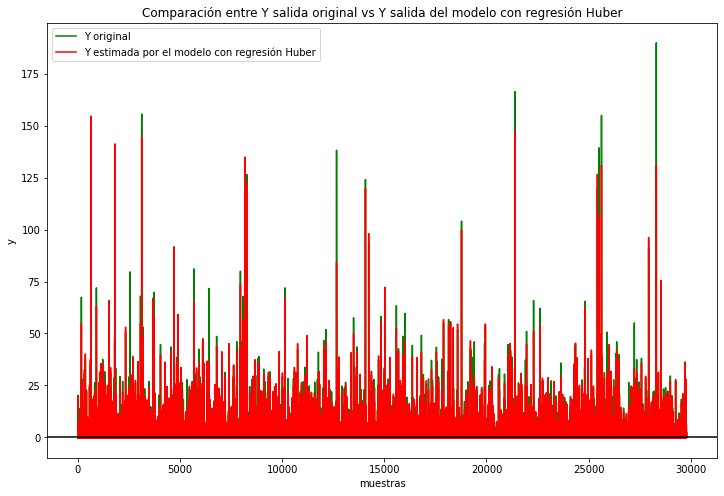

In [17]:
url = RUTA_DATA_GRANDES + '/' + df_resultados_grandes_sort.at[0,'NOMBRE']
opc = df_resultados_grandes_sort.at[0,'CONFIG']
grafica_mejor(url, opc)